In [1]:
import logging
import time
from diskchef.model.model import Model
from pathlib import Path
import astropy.table
from diskchef.lamda.line import Line
from diskchef.physics.yorke_bodenheimer import YorkeBodenheimer2008
from diskchef.uv.uvfits_to_visibilities_ascii import UVFits
from astropy import units as u
import numpy as np
import emcee
from multiprocessing import Pool
import tempfile
import spectral_cube


In [2]:
data_folder = Path("Default")

data = astropy.table.QTable.read(data_folder / "fluxes.ecsv")

lines = [
    # Line(name='HCN J=3-2', transition=3, molecule='HCN'),
    # Line(name='HCO+ J=3-2', transition=3, molecule='HCO+'),
    # Line(name='N2H+ J=3-2', transition=3, molecule='N2H+'),
    Line(name='CO J=2-1', transition=2, molecule='CO'),
]

data["Error"] = 0.1 * data["Flux"]
data

Transition,Flux,Error
,km mJy / s,km mJy / s
str10,float64,float64
HCN J=3-2,1510.80671943462,151.080671943462
HCO+ J=3-2,660.9002134066193,66.09002134066193
N2H+ J=3-2,234.2927466268766,23.42927466268766
CO J=2-1,1942.5746273385303,194.25746273385303


#### Read UVFits of PRODIGE data

And sample the "Default" model with the same visibitities

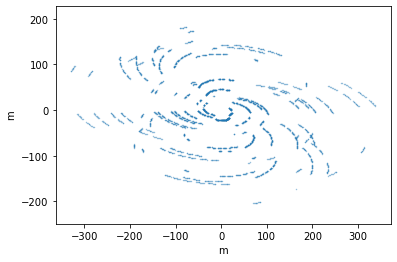

In [3]:
uvdata = UVFits("s-Line-22-CO_1+D.uvfits", 'all', sum=False)
uvdata.plot_uvgrid()
uvdata.image_to_visibilities(Path("Default") / "radmc_gas" / "CO J=2-1_image.fits")

In [4]:
uvdata.table

u,v,Re [21],Im [21],Weight [21]
m,m,Jy,Jy,1 / Jy2
float64,float64,float64,float64,float64
108.18473052980072,-76.8201293945423,0.0025773879578643924 .. 0.002585459343726411,0.00019393749694885436 .. -0.00011904130269154231,1.0 .. 1.0
-28.46938514709882,64.38523101807567,0.002585738833693283 .. 0.002586667860273464,-5.110018890959867e-05 .. 0.0001295539059630694,1.0 .. 1.0
-136.65390014650401,141.2056884765828,0.0025720207965236404 .. 0.002575140881163468,-0.00024475104777731767 .. 0.0002481547429767964,1.0 .. 1.0
-31.257417678837502,-80.41857147217954,0.002585609947494682 .. 0.002582632169205997,-5.6104581747814773e-05 .. -0.00019365927940917976,1.0 .. 1.0
-139.44213867189504,-3.5983760356908254,0.002571417095738951 .. 0.002585859041166592,-0.00024971918720768607 .. -7.4539291138583e-05,1.0 .. 1.0
-2.7886781692508893,-144.8037261963099,0.002586470400721301 .. 0.0025699888464006853,-5.004584834724036e-06 .. -0.00032264548997099546,1.0 .. 1.0
-134.00334167482396,-83.07002258301975,0.0025725857165808962 .. 0.0025752681817988966,-0.00024002771328699758 .. -0.00024819034185675793,1.0 .. 1.0
-242.18806457523016,-6.249906539917891,0.002541426338085151 .. 0.0025775089589889118,-0.000431676476331216 .. -0.0001288920400133232,1.0 .. 1.0


#### Initialize lnprob function

In [5]:
yb = YorkeBodenheimer2008()
def lnprob(params):
    mass = params[0] * u.M_sun
    if params[0] <= 0: return -np.inf
    if params[3] <= 0: return -np.inf
    folder = Path(tempfile.mkdtemp(prefix="fit_", dir="fit3"))
    try:
        demo_model = Model(
            disk="Fit",
            line_list=lines,
            params=dict(r_min=1 * u.au, r_max=300 * u.au, radial_bins=40, vertical_bins=40),
            rstar=yb.radius(mass),
            tstar=yb.effective_temperature(mass),
            inc=params[1] * u.deg,
            PA=params[2] * u.deg,
            distance=params[3] * u.pc,
            # nphot_therm=3e5,
            npix=120,
            channels=21,
            folder=folder,
            run_mctherm=False,
        )
        chi_squared = uvdata.chi2_with(folder / "radmc_gas" / "CO J=2-1_image.fits")
        # fluxes = astropy.table.QTable.read(folder / "fluxes.ecsv")
        # if not np.all(fluxes["Transition"] == data["Transition"]):
        #     raise ValueError("Wrong order of transitions")
        # chi_squared = np.sum(((data["Flux"] - fluxes["Flux"]) / data["Error"]) ** 2)
    except Exception as e:
        logging.error(e)
        return -np.inf
    return -0.5 * chi_squared

In [6]:
nwalkers = 8
ndims = 4
nsteps = 4
trues = np.array([1, 30, 25, 150])

initials = np.random.uniform(0.5, 2, [nwalkers, ndims]) * trues

In [7]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndims, lnprob, pool=pool)
    start = time.time()
    sampler.run_mcmc(initials, nsteps, progress=True)
    end = time.time()

/home/smirnov/anaconda3/envs/latest/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/smirnov/anaconda3/envs/latest/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/smirnov/anaconda3/envs/latest/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/smirnov/anaconda3/envs/latest/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator QuantileTransfo

In [ ]:
sampler.flatchain

In [ ]:
from matplotlib import pyplot as plt
import pickle

In [ ]:
with open("fit/sampler.pkl", "wb") as pkl:
    pickle.dump(sampler, pkl)

In [ ]:
import corner
import matplotlib.colors, matplotlib.cm

In [ ]:
fig = corner.corner(sampler.flatchain, labels=["mass", "inclination", "PA", "distance"], truths=trues,
                    plot_contours=False, plot_density=False)
for point, color in zip(
        sampler.flatchain,
        matplotlib.cm.get_cmap("viridis")(
            matplotlib.colors.Normalize()(sampler.flatlnprobability)
        )
):
    corner.overplot_points(
        fig, [point], color=color
    )

In [ ]:
matplotlib.colors.Normalize()(sampler.flatlnprobability)

In [ ]:
# mass = 1*u.solMass
# demo_model = Model(
#     disk="Fit",
#     line_list=lines,
#     params=dict(r_min=1 * u.au, r_max=300 * u.au, radial_bins=40, vertical_bins=40),
#     rstar=yb.radius(mass),
#     tstar=yb.effective_temperature(mass),
#     inc=30 * u.deg,
#     PA=30 * u.deg,
#     distance=140 * u.pc,
#     nphot_therm=3e5,
#     npix=120,
#     channels=21,
#     folder="demo",
#     run_mctherm=True,
# )

In [ ]:
# demo_model.plot(smooth_triangulation=True)

In [ ]:
# spectrum = astropy.table.QTable.read("demo/CO J=2-1_spectrum.ecsv")
# spectrum

In [ ]:
# from matplotlib import pyplot as plt
# plt.plot(spectrum["Velocity"], spectrum["Flux density"])
# plt.savefig("demo/spectrum.png")